# Function for Cluster Plot w/ Basic Linear Regression
## Example Parameter: Avg Leaf Nitrogen Concentration (LNC) vs Leaf Carbon Nitrogen Ratio (LCN)
#### Author: Heather Childers & Sofia Ingersoll 
##### Date: 2024-02-18

##### Loading environment settings

In [1]:
# moved the libraries that were here into utils.py because they're essential
# xarray is required to run the utils import line
import xarray as xr
import glob

In [2]:
# import libraries & data pre-processing functions from utils.py
from utils import *

##### Request additional processing power from server

In [3]:
# Request an additional 10 cores of power for processing from the server
client = get_cluster("UCSB0021", cores = 15)

/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34483 instead
  warnings.warn(


In [4]:
# apply peer2peer network communication across multiple devices
client.cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/singersoll/proxy/34483/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.103:33869,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/singersoll/proxy/34483/status,Total threads: 0
Started: Just now,Total memory: 0 B


### By loading utils,

A dummy data array `da` & data set `ds` were loaded into our local environment. This is a pre-processed data, the array is of the data variable of interest: LNC: leaf nitrogen content. 

In addition to the dummy data, the functions defined in the utils.py library are also now accesible in this notebook and my be utilized to wrangle the cluster data that is to be read in.

In [5]:
# LNC data array read in with utils library
da

<xarray.DataArray 'LNC' (time: 120, gridcell: 400)>
[48000 values with dtype=float32]
Coordinates:
  * time     (time) object 2005-02-01 00:00:00 ... 2015-01-01 00:00:00
Dimensions without coordinates: gridcell
Attributes:
    long_name:     leaf N concentration
    units:         gN leaf/m^2
    cell_methods:  time: mean

In [6]:
# data set read in with utils library
ds

<xarray.Dataset>
Dimensions:                            (levgrnd: 25, levsoi: 20, levlak: 10,
                                        levdcmp: 25, time: 120,
                                        hist_interval: 2, lon: 144, lat: 96,
                                        gridcell: 400, landunit: 1148,
                                        column: 2599, pft: 4387, cft: 2,
                                        ltype: 9, nvegwcs: 4)
Coordinates:
  * levgrnd                            (levgrnd) float32 0.01 0.04 ... 42.0
  * levsoi                             (levsoi) float32 0.01 0.04 ... 6.94 8.03
  * levlak                             (levlak) float32 0.05 0.6 ... 34.33 44.78
  * levdcmp                            (levdcmp) float32 0.01 0.04 ... 42.0
  * time                               (time) object 2005-02-01 00:00:00 ... ...
  * lon                                (lon) float32 0.0 2.5 5.0 ... 355.0 357.5
  * lat                                (lat) float32 -90.0 -88.11 ... 88.11 90.0
Dimensions without coordinates: hist_interval, gridcell, landunit, column, pft,
                                cft, ltype, nvegwcs
Data variables: (12/497)
    mcdate                             (time) int32 ...
    mcsec                              (time) int32 ...
    mdcur                              (time) int32 ...
    mscur                              (time) int32 ...
    nstep                              (time) int32 ...
    time_bounds                        (time, hist_interval) object ...
    ...                                 ...
    XSMRPOOL                           (time, gridcell) float32 ...
    XSMRPOOL_RECOVER                   (time, gridcell) float32 ...
    ZBOT                               (time, gridcell) float32 ...
    ZWT                                (time, gridcell) float32 ...
    ZWT_CH4_UNSAT                      (time, gridcell) float32 ...
    ZWT_PERCH                          (time, gridcell) float32 ...
Attributes: (12/40)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 09/06/23 02:33:14
    source:                                    Community Terrestrial Systems ...
    hostname:                                  cheyenne
    ...                                        ...
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1
    Time_constant_3Dvars_filename:             ./PPEn11_CTL2010_OAAT0000.clm2...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

## Loading a Cluster of 500 files
The data files are located in `/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/`

The 2005-2010 monthly output files have the form:
`PPEn11_transient_LHC0001.clm2.h0.2005-02-01-00000.nc`

We're interested in files spanning from:
`LHC0001 to LHC0500`

**NOTE:The current set up for loading in the data cluster gives a warning about the size being so large it will slow down. A message at the bottom of my browser says "Initialized (additional servers needed) Mem: 2.67/10 GB". I think I will increase my core processing request to 15 and see if that improves the computing issue.**

In [ ]:
# Open multiple files as a single dataset
file_cluster = sorted(glob.glob('/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC*[0001-501].*'))

cluster_ds = xr.open_mfdataset(file_cluster,
                              combine = 'nested',
                              parallel = True,
                              concat_dim = "ens")

/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 29.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



##### Accessing data processing functions from utils.py library

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----    Wrangle  Cluster Data     ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Subset for the variable of interest LNC and properly weigh grid cells and time dim
# these functions are defined in the utils library 
cluster_ds = cluster_ds['LNC'].weighted_landarea_gridcells(landarea).yearly_weighted_average().fix_time()

### Leaf Carbon : Nitrogen Data

This will come in handy later when we want to plot trends overtime

In [26]:
# Leaf CN data for plotting
df = pd.read_csv('/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt',index_col=0)
# convert to data set
params = xr.Dataset(df)

# the only dimension here is the 'member' aka file index id [LCH0001-500]
params

# subsetting for leafcn
leafcn = params['leafcn']

#leafcn

<xarray.Dataset>
Dimensions:              (member: 500)
Coordinates:
  * member               (member) object 'LHC0001' 'LHC0002' ... 'LHC0500'
Data variables: (12/32)
    FUN_fracfixers       (member) float64 0.7783 0.3193 0.8768 ... 0.2621 0.4221
    KCN                  (member) float64 0.358 0.5488 0.2108 ... 0.9123 0.8392
    a_fix                (member) float64 0.255 0.6302 0.6621 ... 0.5339 0.1443
    crit_dayl            (member) float64 0.4012 0.27 0.3534 ... 0.9974 0.6571
    d_max                (member) float64 0.7978 0.5361 0.1409 ... 0.9076 0.4009
    fff                  (member) float64 0.1301 0.6792 ... 0.9918 0.02798
    ...                   ...
    stem_leaf            (member) float64 0.1138 0.1273 0.25 ... 0.3328 0.347
    sucsat_sf            (member) float64 0.7982 0.3947 0.1681 ... 0.3526 0.6515
    theta_cj             (member) float64 0.03646 0.09374 ... 0.8429 0.5055
    tpu25ratio           (member) float64 0.3936 0.04108 0.8197 ... 0.716 0.2124
    tpuse_sf             (member) float64 0.07896 0.2756 0.8401 ... 0.353 0.3634
    wc2wjb0              (member) float64 0.6846 0.8785 0.9519 ... 0.3581 0.1567

### Visualize Cluster Plot with Linear Regression

**NOTE: For right now we're using the dummy data until we're able to load in the cluster files**

In [45]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----     Subsetting Dummy Data    ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# only the da was pre_processed, so we're weighing the ds here and making an array
leafcn_da = ds['LEAFCN'].dropna('gridcell')

leafcn_da

<xarray.DataArray 'LEAFCN' (time: 120, gridcell: 391)>
array([[27.742062, 29.9028  , 22.932922, ..., 14.971134, 17.946583, 11.910461],
       [27.80434 , 29.965092, 22.965727, ..., 14.971134, 17.946583, 11.910461],
       [30.084639, 31.38103 , 23.44602 , ..., 14.971134, 17.946583, 11.910461],
       ...,
       [27.745855, 30.45497 , 22.94266 , ..., 14.971134, 17.946583, 11.910461],
       [27.693804, 29.878855, 22.910887, ..., 14.971134, 17.946583, 11.910461],
       [27.69334 , 29.861938, 22.90841 , ..., 14.971134, 17.946583, 11.910461]],
      dtype=float32)
Coordinates:
  * time     (time) object 2005-02-01 00:00:00 ... 2015-01-01 00:00:00
Dimensions without coordinates: gridcell
Attributes:
    long_name:     Leaf CN ratio used for flexible CN
    units:         gC/gN
    cell_methods:  time: mean

**This is not working for our time dimension on leafcn_da**

In [38]:
# only the da was pre_processed, so we're weighing the ds here and making an array
leafcn_da = yearly_weighted_average(leafcn_da)
#.fix_time()

KeyError: 'time'

In [48]:
da

<xarray.DataArray 'LNC' (time: 120, gridcell: 390)>
array([[1.613954, 1.753002, 2.081427, ..., 0.      , 0.      , 0.      ],
       [1.609656, 1.749582, 2.078473, ..., 0.      , 0.      , 0.      ],
       [1.205587, 1.479927, 1.974838, ..., 0.      , 0.      , 0.      ],
       ...,
       [1.613913, 1.662436, 2.081528, ..., 0.      , 0.      , 0.      ],
       [1.617108, 1.754788, 2.083673, ..., 0.      , 0.      , 0.      ],
       [1.617131, 1.755294, 2.083596, ..., 0.      , 0.      , 0.      ]],
      dtype=float32)
Coordinates:
  * time     (time) object 2005-02-01 00:00:00 ... 2015-01-01 00:00:00
Dimensions without coordinates: gridcell
Attributes:
    long_name:     leaf N concentration
    units:         gN leaf/m^2
    cell_methods:  time: mean

ValueError: x and y must be the same size

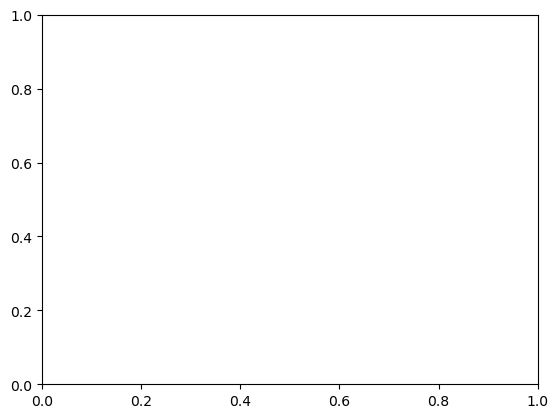

In [47]:
# Creating Linear Regression for LNC

# using utils pre-processed data array for LNC
# split into training & testing (90/10)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
#from sklearn_xarray import Stacker, Select


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Split Data 90/10        ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
da = da.dropna('gridcell')

X_train, X_test, y_train, y_test = train_test_split(leafcn_da, da, test_size = 0.1, random_state=0)


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Linear Regression       ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

y_pred = regressor.predict(X_test)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----    Plot Linear Regression    ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plt.scatter(X_train, y_train,color='g')
plt.plot(X_test, y_pred,color='k')

plt.show()

In [ ]:
# calculate global mean over time
LNC_avg = da.mean(dim = 'time')

# plot mean tsa overtime of weighted gridcells
plt.figure(figsize = (9,4))
plt.scatter(leafcn_da,
            LNC_avg,
            c = LNC_avg,
           cmap = 'RdPu',
           alpha = 0.5)
plt.xlabel('Leaf Carbon Nitrogen Ratio')
plt.ylabel('Leaf Nitrogen Concentration')
plt.title('Default Simulation: OAAT0000')
plt.colorbar(label = 'Concenctration (units to be added)')

### Down sampled 2 file approach

In [ ]:
# Set filepath
#filepath = '/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/'

In [ ]:
#members = ["LHC" + str(i).zfill(4) for i in range(1,501)]
#members

In [ ]:
#Open multiple files as a single dataset
ds_mf =xr.open_mfdataset(['/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC0001.clm2.h0.2005-02-01-00000.nc', 
                          '/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC0002.clm2.h0.2005-02-01-00000.nc'], 
                         combine='nested', parallel=True, concat_dim = "ens")

In [ ]:
ds_mf.time

In [ ]:
ds.time.max()

In [ ]:
file2 = '/glade/campaign/cgd/tss/projects/PPE/helpers/sparsegrid_landarea.nc'
ds2 = xr.open_dataset(file2)
landarea = ds2['landarea']
weighted_avg_area = ds_mf['TSA'].weighted(landarea).mean(dim = 'gridcell').mean(dim = 'time')
weighted_avg_area.values

#### Single file visualization of LNC

In [ ]:
# these are commented out because the utils library provides the same information in line 2
#file = "/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC0001.clm2.h0.2005-02-01-00000.nc"
#ds = xr.open_dataset(file)

In [ ]:
lnc = ds['LNC']
lnc_timeavg = lnc.mean(dim = 'time')

In [ ]:
plt.scatter(ds.grid1d_lon,
            ds.grid1d_lat,
            c=lnc_timeavg)

In [ ]:
#lnc_avg = lnc_timeavg.mean(dim = 'lat')